# Data API


This tutorial is separated into three main parts: the first two parts shows how to find and get data to do impact calculations and should be enough for most users. The third part provides more detailed information on how the API is built.

## Contents

- [Finding Datasets](#Finding-datasets)
    - [Data types and data type groups](#Data-types-and-data-type-groups)
    - [Datasets and Properties](#Datasets-and-Properties)
- [Basic impact calculation](#Basic-impact-calculation)
    - [Wrapper functions to open datasets as PINAR objects](#Wrapper-functions-to-open-datasets-as-PINAR-objects)
    - [Calculate the impact](#Calculate-the-impact)
- [Technical Information](#Technical-Information)
    - [Server](#Server)
    - [Client](#Client)
    - [Metadata](#Metadata)
    - [Download](#Download)

## Finding datasets

In [3]:
from pinar.util.api_client import Client
client = Client()

### Data types and data type groups
The datasets are first separated into 'data_type_groups', which represent the main classes of PINAR (exposures, hazard, vulnerability, ...). So far, data is available for exposures and hazard. Then, data is separated into data_types, representing the different hazards and exposures available in PINAR

In [2]:
import pandas as pd
data_types = client.list_data_type_infos()

dtf = pd.DataFrame(data_types)
dtf.sort_values(['data_type_group', 'data_type'])

,data_type,data_type_group,status,description,properties
3,crop_production,exposures,active,None,"[{'property': 'crop', 'mandatory': True, 'desc..."
0,litpop,exposures,active,None,"[{'property': 'res_arcsec', 'mandatory': False..."
5,centroids,hazard,active,None,[]
2,river_flood,hazard,active,None,"[{'property': 'res_arcsec', 'mandatory': False..."
4,storm_europe,hazard,active,None,"[{'property': 'country_iso3alpha', 'mandatory'..."
1,tropical_cyclone,hazard,active,None,"[{'property': 'res_arcsec', 'mandatory': True,..."


### Datasets and Properties
For each data type, the single datasets can be differentiated based on properties. The following function provides a table listing the properties and possible values. This table does not provide information on properties that can be combined but the search can be refined in order to find properties to query a unique dataset. Note that a maximum of 10 property values are shown here, but many more countries are available for example.

In [3]:
litpop_dataset_infos = client.list_dataset_infos(data_type='litpop')

In [4]:
all_properties = client.get_property_values(litpop_dataset_infos)

In [5]:
all_properties.keys()

dict_keys(['res_arcsec', 'exponents', 'fin_mode', 'spatial_coverage', 'country_iso3alpha', 'country_name', 'country_iso3num'])

#### Refining the search:

In [6]:
# as datasets are usually available per country, chosing a country or global dataset reduces the options
# here we want to see which datasets are available for litpop globally:
client.get_property_values(litpop_dataset_infos, known_property_values = {'spatial_coverage':'global'})

{'res_arcsec': ['150'],
 'exponents': ['(0,1)', '(1,1)', '(3,0)'],
 'fin_mode': ['pop', 'pc'],
 'spatial_coverage': ['global']}

In [7]:
#and here for Switzerland:
client.get_property_values(litpop_dataset_infos, known_property_values = {'country_name':'Switzerland'})

{'res_arcsec': ['150'],
 'exponents': ['(3,0)', '(0,1)', '(1,1)'],
 'fin_mode': ['pc', 'pop'],
 'spatial_coverage': ['country'],
 'country_iso3alpha': ['CHE'],
 'country_name': ['Switzerland'],
 'country_iso3num': ['756']}

## Basic impact calculation
We here show how to make a basic impact calculation with tropical cyclones for Haiti, for the year 2040, rcp4.5  and generated with 10 synthetic tracks. For more technical details on the API, see below.



### Wrapper functions to open datasets as PINAR objects

#### The wrapper functions client.get_hazard() 
gets the dataset information, downloads the data and opens it as a hazard instance


In [8]:
tc_dataset_infos = client.list_dataset_infos(data_type='tropical_cyclone')
client.get_property_values(tc_dataset_infos, known_property_values = {'country_name':'Haiti'})

{'res_arcsec': ['150'],
 'pinar_scenario': ['rcp26', 'rcp45', 'rcp85', 'historical', 'rcp60'],
 'ref_year': ['2040', '2060', '2080'],
 'nb_synth_tracks': ['50', '10'],
 'spatial_coverage': ['country'],
 'tracks_year_range': ['1980_2020'],
 'country_iso3alpha': ['HTI'],
 'country_name': ['Haiti'],
 'country_iso3num': ['332'],
 'resolution': ['150 arcsec']}

In [ ]:
client = Client()
tc_haiti = client.get_hazard('tropical_cyclone', properties={'country_name': 'Haiti', 'pinar_scenario': 'rcp45', 'ref_year':'2040', 'nb_synth_tracks':'10'})
tc_haiti.plot_intensity(0);

#### The wrapper functions client.get_litpop() 
gets the default litpop, with exponents (1,1) and 'produced capital' as financial mode. If no country is given, the global dataset will be downloaded.

In [10]:
litpop_default = client.get_property_values(litpop_dataset_infos, known_property_values = {'fin_mode':'pc', 'exponents':'(1,1)'})

In [ ]:
litpop = client.get_litpop(country='Haiti')

#### Get the default impact function for tropical cyclones

2022-01-31 22:30:21,359 - pinar.entity.impact_funcs.base - WARNING - For intensity = 0, mdd != 0 or paa != 0. Consider shifting the origin of the intensity scale. In impact.calc the impact is always null at intensity = 0.


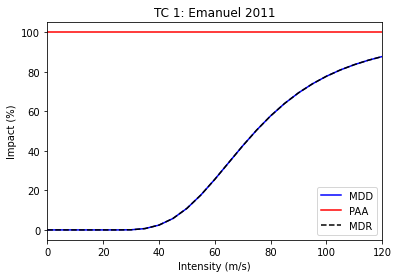

In [12]:
from pinar.entity.impact_funcs import ImpactFuncSet, ImpfTropCyclone

imp_fun = ImpfTropCyclone.from_emanuel_usa()
imp_fun.check()
imp_fun.plot()

imp_fun_set = ImpactFuncSet([imp_fun])

litpop.impact_funcs = imp_fun_set

### Calculate the impact

In [13]:
from pinar.engine import ImpactCalc
impact = ImpactCalc(litpop, imp_fun_set, tc_haiti).impact()

#### Getting other Exposures

In [14]:
crop_dataset_infos = client.list_dataset_infos(data_type='crop_production')

client.get_property_values(crop_dataset_infos)

{'crop': ['whe', 'soy', 'ric', 'mai'],
 'irrigation_status': ['noirr', 'firr'],
 'unit': ['USD', 'Tonnes'],
 'spatial_coverage': ['global']}

In [15]:
rice_exposure = client.get_exposures(exposures_type='crop_production', properties = {'crop':'ric', 'unit': 'USD','irrigation_status': 'noirr'})

### Getting base centroids to generate new hazard files

https://pinar.ethz.ch/data-api/v1/dataset	data_type=centroids	extent=(-180, 180, -90, 90)	limit=100000	name=None	res_arcsec_land=150	res_arcsec_ocean=1800	status=active	version=None
2022-07-01 15:59:42,013 - pinar.hazard.centroids.centr - INFO - Reading /Users/szelie/pinar/data/centroids/earth_centroids_150asland_1800asoceans_distcoast_regions/v1/earth_centroids_150asland_1800asoceans_distcoast_region.hdf5
2022-07-01 15:59:44,273 - pinar.util.plot - WARNING - Error parsing coordinate system 'GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degre

<GeoAxesSubplot:>

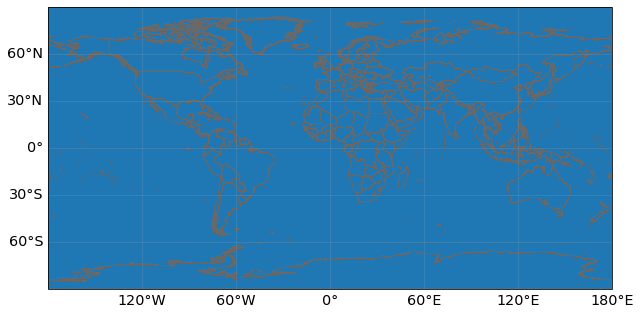

In [13]:
centroids = client.get_centroids()
centroids.plot()

For many hazards, limiting the latitude extent to [-60,60] is sufficient and will reduce the computational ressources required

https://pinar.ethz.ch/data-api/v1/dataset	data_type=centroids	extent=(-180, 180, -90, 90)	limit=100000	name=None	res_arcsec_land=150	res_arcsec_ocean=1800	status=active	version=None
2022-07-01 15:59:27,602 - pinar.hazard.centroids.centr - INFO - Reading /Users/szelie/pinar/data/centroids/earth_centroids_150asland_1800asoceans_distcoast_regions/v1/earth_centroids_150asland_1800asoceans_distcoast_region.hdf5
2022-07-01 15:59:29,255 - pinar.util.plot - WARNING - Error parsing coordinate system 'GEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degre

<GeoAxesSubplot:>

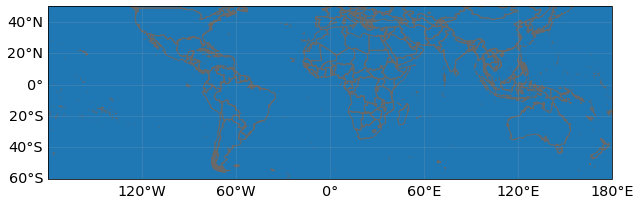

In [12]:
centroids_nopoles = client.get_centroids(extent=[-180,180,-60,50])
centroids_nopoles.plot()

centroids are also available per country:

In [ ]:
centroids_hti = client.get_centroids(country='HTI')

## Technical Information

For programmatical access to the PINAR data API there is a specific REST call wrapper class: `pinar.util.client.Client`.

### Server
The PINAR data file server is hosted on https://data.iac.ethz.ch that can be accessed via a REST API at https://pinar.ethz.ch.
For REST API details, see the [documentation](https://pinar.ethz.ch/rest/docs).

### Client

In [16]:
Client?

Init signature: Client()
Docstring:     
Python wrapper around REST calls to the PINAR data API server.
    
Init docstring:
Constructor of Client.

Data API host and chunk_size (for download) are configurable values.
Default values are 'pinar.ethz.ch' and 8096 respectively.
File:           c:\users\me\polybox\workshop\pinar_python\pinar\util\api_client.py
Type:           type
Subclasses:     


In [17]:
client = Client()
client.chunk_size

8192

The url to the API server and the chunk size for the file download can be configured in 'pinar.conf'. Just replace the corresponding default values:

```json
    "data_api": {
        "host": "https://pinar.ethz.ch",
        "chunk_size": 8192,
        "cache_db": "{local_data.system}/.downloads.db"
    }
```

The other configuration value affecting the data_api client, `cache_db`, is the path to an SQLite database file, which is keeping track of the files that are successfully downloaded from the api server. Before the Client attempts to download any file from the server, it checks whether the file has been downloaded before and if so, whether the previously downloaded file still looks good (i.e., size and time stamp are as expected). If all of this is the case, the file is simply read from disk without submitting another request.

### Metadata

#### Unique Identifiers
Any dataset can be identified with **data_type**, **name** and **version**. The combination of the three is unique in the API servers' underlying database.
However, sometimes the name is already enough for identification.
All datasets have a UUID, a universally unique identifier, which is part of their individual url. 

In [18]:
client.get_dataset_info_by_uuid('b1c76120-4e60-4d8f-99c0-7e1e7b7860ec')

DatasetInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', data_type=DataTypeShortInfo(data_type='litpop', data_type_group='exposures'), name='LitPop_assets_pc_150arcsec_SGS', version='v1', status='active', properties={'res_arcsec': '150', 'exponents': '(3,0)', 'fin_mode': 'pc', 'spatial_coverage': 'country', 'date_creation': '2021-09-23', 'pinar_version': 'v2.2.0', 'country_iso3alpha': 'SGS', 'country_name': 'South Georgia and the South Sandwich Islands', 'country_iso3num': '239'}, files=[FileInfo(uuid='b1c76120-4e60-4d8f-99c0-7e1e7b7860ec', url='https://data.iac.ethz.ch/pinar/b1c76120-4e60-4d8f-99c0-7e1e7b7860ec/LitPop_assets_pc_150arcsec_SGS.hdf5', file_name='LitPop_assets_pc_150arcsec_SGS.hdf5', file_format='hdf5', file_size=1086488, check_sum='md5:27bc1846362227350495e3d946dfad5e')], doi=None, description="LitPop asset value exposure per country: Gridded physical asset values by country, at a resolution of 150 arcsec. Values are total produced capital values disaggregated proportion

or by filtering:

#### Data Set Status
The datasets of API may have the following stati:
- **active**: the default for real life data
- **preliminary**: when the dataset is already uploaded but some information or file is still missing
- **expired**: when a dataset is inactivated again
- **test_dataset**: data sets that are used in unit or integration tests have this status in order to be taken seriously by accident
When collecting a list of datasets with `get_datasets`, the default dataset status will be 'active'. With the argument `status=None` this filter can be turned off.

#### DatasetInfo Objects and DataFrames

As stated above `get_dataset` (or `get_dataset_by_uuid`) return a `DatasetInfo` object and `get_datasets` a list thereof.

In [19]:
from pinar.util.api_client import DatasetInfo
DatasetInfo?

Init signature:
DatasetInfo(
    uuid: str,
    data_type: pinar.util.api_client.DataTypeShortInfo,
    name: str,
    version: str,
    status: str,
    properties: dict,
    files: list,
    doi: str,
    description: str,
    license: str,
    activation_date: str,
    expiration_date: str,
) -> None
Docstring:      dataset data from PINAR data API.
File:           c:\users\me\polybox\workshop\pinar_python\pinar\util\api_client.py
Type:           type
Subclasses:     


where files is a list of `FileInfo` objects:

In [20]:
from pinar.util.api_client import FileInfo
FileInfo?

Init signature:
FileInfo(
    uuid: str,
    url: str,
    file_name: str,
    file_format: str,
    file_size: int,
    check_sum: str,
) -> None
Docstring:      file data from PINAR data API.
File:           c:\users\me\polybox\workshop\pinar_python\pinar\util\api_client.py
Type:           type
Subclasses:     


#### Convert into DataFrame
There are conveinience functions to easily convert datasets into pandas DataFrames, `get_datasets` and `expand_files`:

In [21]:
client.into_datasets_df?

Signature: client.into_datasets_df(dataset_infos)
Docstring:
Convenience function providing a DataFrame of datasets with properties.

Parameters
----------
dataset_infos : list of DatasetInfo
     as returned by list_dataset_infos

Returns
-------
pandas.DataFrame
    of datasets with properties as found in query by arguments
File:      c:\users\me\polybox\workshop\pinar_python\pinar\util\api_client.py
Type:      function


In [22]:
from pinar.util.api_client import Client
client = Client()
litpop_datasets = client.list_dataset_infos(data_type='litpop', properties={'country_name': 'South Georgia and the South Sandwich Islands'})
litpop_df = client.into_datasets_df(litpop_datasets)
litpop_df

,data_type,data_type_group,uuid,name,version,status,doi,description,license,activation_date,expiration_date,res_arcsec,exponents,fin_mode,spatial_coverage,date_creation,pinar_version,country_iso3alpha,country_name,country_iso3num
0,litpop,exposures,b1c76120-4e60-4d8f-99c0-7e1e7b7860ec,LitPop_assets_pc_150arcsec_SGS,v1,active,None,LitPop asset value exposure per country: Gridd...,Attribution 4.0 International (CC BY 4.0),2021-09-13 09:08:28.358559+00:00,None,150,"(3,0)",pc,country,2021-09-23,v2.2.0,SGS,South Georgia and the South Sandwich Islands,239
1,litpop,exposures,3d516897-5f87-46e6-b673-9e6c00d110ec,LitPop_pop_150arcsec_SGS,v1,active,None,LitPop population exposure per country: Gridde...,Attribution 4.0 International (CC BY 4.0),2021-09-13 09:09:10.634374+00:00,None,150,"(0,1)",pop,country,2021-09-23,v2.2.0,SGS,South Georgia and the South Sandwich Islands,239
2,litpop,exposures,a6864a65-36a2-4701-91bc-81b1355103b5,LitPop_150arcsec_SGS,v1,active,None,LitPop asset value exposure per country: Gridd...,Attribution 4.0 International (CC BY 4.0),2021-09-13 09:09:30.907938+00:00,None,150,"(1,1)",pc,country,2021-09-23,v2.2.0,SGS,South Georgia and the South Sandwich Islands,239


### Download

The wrapper functions get_exposures or get_hazard fetch the information, download the file and opens the file as a pinar object. But one can also just download dataset files using the method `download_dataset` which takes a `DatasetInfo` object as argument and downloads all files of the dataset to a directory in the local file system.

In [23]:
client.download_dataset?

Signature:
client.download_dataset(
    dataset,
    target_dir=WindowsPath('C:/Users/me/pinar/data'),
    organize_path=True,
)
Docstring:
Download all files from a given dataset to a given directory.

Parameters
----------
dataset : DatasetInfo
    the dataset
target_dir : Path, optional
    target directory for download, by default `pinar.util.constants.SYSTEM_DIR`
organize_path: bool, optional
    if set to True the files will end up in subdirectories of target_dir:
    [target_dir]/[data_type_group]/[data_type]/[name]/[version]
    by default True

Returns
-------
download_dir : Path
    the path to the directory containing the downloaded files,
    will be created if organize_path is True
downloaded_files : list of Path
    the downloaded files themselves

Raises
------
Exception
    when one of the files cannot be downloaded
File:      c:\users\me\polybox\workshop\pinar_python\pinar\util\api_client.py
Type:      method


#### Cache
The method avoids superfluous downloads by keeping track of all downloads in a sqlite db file. The client will make sure that the same file is never downloaded to the same target twice.

#### Examples

In [24]:
# Let's have a look at an example for downloading a litpop dataset first
ds = litpop_datasets[0]  # litpop_datasets is a list and download_dataset expects a single object as argument.
download_dir, ds_files = client.download_dataset(ds)
ds_files[0], ds_files[0].is_file()

(WindowsPath('C:/Users/me/pinar/data/exposures/litpop/LitPop_assets_pc_150arcsec_SGS/v1/LitPop_assets_pc_150arcsec_SGS.hdf5'),
 True)

In [8]:
# Another example for downloading a hazard (tropical cyclone) dataset
ds_tc = tc_dataset_infos[0] 
download_dir, ds_files = client.download_dataset(ds_tc)
ds_files[0], ds_files[0].is_file()

(PosixPath('/home/yuyue/pinar/data/hazard/tropical_cyclone/tropical_cyclone_50synth_tracks_150arcsec_rcp26_BRA_2040/v1/tropical_cyclone_50synth_tracks_150arcsec_rcp26_BRA_2040.hdf5'),
 True)

### Offline Mode

The API Client is silently used in many methods and functions of PINAR, including the installation test that is run to see whether the PINAR installation was successful.
Most methods of the client send GET requests to the API server assuming the latter is accessible through a working internet connection.
If this is not the case, the functionality of PINAR is severely limited if not altogether lost. Often this is an unnecessary restriction, 
e.g., when a user wants to access a file through the API Client that is already downloaded and available in the local filesystem.

In such cases the API Client runs in _offline mode_.
In this mode the client falls back to previous results for the same call in case there is no internet connection or the server is not accessible.

To turn this feature off and make sure that all results are current and up to date - at the cost of failing when there is no internet connection - one has to disable tha _cache_.
This can be done programmatically, by initializing the API Client with the optional argument `cache_enabled`:

In [ ]:
client = Client(cache_enabled=False)

Or it can be done through configuration. Edit the `pinar.conf` file in the working directory or in ~/pinar/ and change the "cache_enabled" value, like this:

```javascript
...
    "data_api": {
        ...
        "cache_enabled": false
    },
...
```

While `cache_enabled` is `true` (default), every result from the server is stored as a json file in ~/pinar/data/.apicache/ by a unique name derived from the method and arguments of the call.
If the very same call is made again later, at a time where the server is not accessible, the client just comes back to the cached result from the previous call.